In [1]:
import RPi.GPIO as GPIO
import gpiozero
import time
import numpy as np
from matplotlib import pyplot as plt


In [2]:
# Constants
# Encoder pins
# ML = motor left, MR = motor right
GPIO.cleanup()

GPIO.setmode(GPIO.BCM)

ML_ENC_A = 23 # yellow encoder c 
ML_ENC_B = 24 # white encoder c

MR_ENC_A = 14 # yellow encoder c
MR_ENC_B = 15 # white encoder c

"""
- gear ratio = 75:1 = motor shaft rotates 75 times each revolution
- encoder = 48 CPR (count per revolution) = 48 counts each shaft rotation
- counts per round = count per rev * rev per round = 48*75 = 3600
"""
MAX_ENC_STEPS = 3600

# Motor Pins
ML_IN1 = 10 # IN1 
ML_IN2 = 22 # IN2
ML_ENA = 9 # brown

MR_IN3 = 27 # IN3
MR_IN4 = 17 # IN4
MR_ENB = 11

# Physical dimensions
WHEEL_RADIUS = 0.056 # meters
WHEEL_SEP = 0.222 # meters


/tmp/ipykernel_3028/4023504698.py:4: RuntimeWarning: No channels have been set up yet - nothing to clean up!  Try cleaning up at the end of your program instead!
  GPIO.cleanup()


In [3]:

# wheel separation measurement (ASCII art)
"""
    <------- l ------->
    |                 |
 ___|___           ___|___
|       |         |       |
|   O   |         |   O   |
|_______|         |_______|
    ^                 ^
    |                 |
  Left wheel       Right wheel
  center            center
"""

class DiffDriveRobot:
    def __init__(
            self, 
            dt=0.1, 
            wheel_radius=WHEEL_RADIUS, 
            wheel_sep=WHEEL_SEP,
            max_enc_steps=MAX_ENC_STEPS,
            ml_pwm=ML_ENA,
            mr_pwm=MR_ENB,
            ml_in1=ML_IN1,
            ml_in2=ML_IN2,
            mr_in3=MR_IN3,
            mr_in4=MR_IN4,
            ml_encA=ML_ENC_A,
            ml_encB=ML_ENC_B,
            mr_encA=MR_ENC_A,
            mr_encB=MR_ENC_B
    ):
        self.x = 0.0  # x-position
        self.y = 0.0  # y-position 
        self.th = 0.0  # orientation
        
        self.wl = 0.0  # rotational velocity left wheel
        self.wr = 0.0  # rotational velocity right wheel
        
        self.dt = dt # time delta in seconds
        self.r = wheel_radius # wheel radius in meters
        self.l = wheel_sep # wheel separation in meters
        self.max_enc_steps = max_enc_steps # steps in the encoder per revolution
        
        # Pin numbers
        self.motor_L_in1 = ml_in1 # Input 1 (motor left)
        self.motor_L_in2 = ml_in2 # Input 2 (motor left)
        self.motor_R_in3 = mr_in3 # Input 3 (motor right)
        self.motor_R_in4 = mr_in4 # Input 4 (motor right)
        GPIO.setup(self.motor_L_in1, GPIO.OUT)
        GPIO.setup(self.motor_L_in2, GPIO.OUT)
        GPIO.setup(self.motor_R_in3, GPIO.OUT)
        GPIO.setup(self.motor_R_in4, GPIO.OUT)      
        
        # Initialize encoders
        self.ML_ENC = gpiozero.RotaryEncoder(a=ml_encA, b=ml_encB, max_steps=max_enc_steps, wrap=True)
        self.MR_ENC = gpiozero.RotaryEncoder(a=mr_encA, b=mr_encB, max_steps=max_enc_steps, wrap=True)
        self.ml_enc_steps = 0 # left motor encoder value (AKA shaft angle) in steps. 
        self.mr_enc_steps = 0 # right motor encoder value (AKA shaft angle) in steps. 

        # Initialize motor control pins
        GPIO.setup(ml_pwm, GPIO.OUT)
        GPIO.setup(mr_pwm, GPIO.OUT)
        self.motor_L_pwm = GPIO.PWM(ml_pwm, 1000)  # 1000 Hz frequency
        self.motor_R_pwm = GPIO.PWM(mr_pwm, 1000)
        self.motor_L_pwm.start(0)
        self.motor_R_pwm.start(0)
        

    def read_wheel_velocities(self):
        ml_enc_now = self.ML_ENC.steps
        mr_enc_now = self.MR_ENC.steps

        # Calculate change in steps, accounting for wrap-around
        ml_enc_delta = (ml_enc_now - self.ml_enc_steps + self.max_enc_steps) % (2 * self.max_enc_steps) - self.max_enc_steps
        mr_enc_delta = (mr_enc_now - self.mr_enc_steps + self.max_enc_steps) % (2 * self.max_enc_steps) - self.max_enc_steps
        
        # Convert step change to radians
        ml_delta_rad = ml_enc_delta / self.max_enc_steps * 2 * np.pi
        mr_delta_rad = mr_enc_delta / self.max_enc_steps * 2 * np.pi

        # Calculate velocities
        self.wl = ml_delta_rad / self.dt
        self.wr = mr_delta_rad / self.dt

        # Update previous steps
        self.ml_enc_steps = ml_enc_now
        self.mr_enc_steps = mr_enc_now

        return self.wl, self.wr
  

    def set_motor_speed(self, left_duty_cycle, right_duty_cycle):
        # Set direction
        GPIO.output(self.motor_L_in1, GPIO.HIGH if left_duty_cycle >= 0 else GPIO.LOW)
        GPIO.output(self.motor_L_in2, GPIO.LOW if left_duty_cycle >= 0 else GPIO.HIGH)
        GPIO.output(self.motor_R_in3, GPIO.HIGH if right_duty_cycle >= 0 else GPIO.LOW)
        GPIO.output(self.motor_R_in4, GPIO.LOW if right_duty_cycle >= 0 else GPIO.HIGH)

        # Set speed
        self.motor_L_pwm.ChangeDutyCycle(abs(left_duty_cycle) * 100)
        self.motor_R_pwm.ChangeDutyCycle(abs(right_duty_cycle) * 100)

    def base_velocity(self, wl, wr):
        v = (wl * self.r + wr * self.r) / 2.0
        w = (wl * self.r - wr * self.r) / self.l
        return v, w

    def pose_update(self, duty_cycle_l, duty_cycle_r):
        
        self.set_motor_speed(duty_cycle_l, duty_cycle_r)
        wl, wr = self.read_wheel_velocities() # get wheel velocities 
        v, w = self.base_velocity(wl, wr)
        
        self.x = self.x + self.dt * v * np.cos(self.th)
        self.y = self.y + self.dt * v * np.sin(self.th)
        self.th = self.th + w * self.dt
        
        return self.x, self.y, self.th

    
class RobotController:
    
    def __init__(self,Kp=0.2,Ki=0.0,wheel_radius=WHEEL_RADIUS, wheel_sep=WHEEL_SEP):
        
        self.Kp = Kp
        self.Ki = Ki
        self.r = wheel_radius
        self.l = wheel_sep
        self.e_sum_l = 0
        self.e_sum_r = 0
        
    def p_control(self,w_desired,w_measured,e_sum):
        
        duty_cycle = min(max(-1,self.Kp*(w_desired-w_measured) + self.Ki*e_sum),1)
        
        e_sum = e_sum + (w_desired-w_measured)
        
        return duty_cycle, e_sum
        
        
    def drive(self,v_desired,w_desired,wl,wr):
        
        wl_desired = (v_desired + self.l*w_desired/2)/self.r
        wr_desired = (v_desired - self.l*w_desired/2)/self.r
        
        duty_cycle_l,self.e_sum_l = self.p_control(wl_desired,wl,self.e_sum_l)
        duty_cycle_r,self.e_sum_r = self.p_control(wr_desired,wr,self.e_sum_r)
        
        return duty_cycle_l, duty_cycle_r

In [4]:
GPIO.setwarnings(False)
robot = DiffDriveRobot()

Position: (0.42, -0.54), Orientation: -1.98
Position: (0.42, -0.54), Orientation: -1.99
Position: (0.42, -0.55), Orientation: -2.00
Position: (0.42, -0.56), Orientation: -2.02
Position: (0.41, -0.56), Orientation: -2.04
Position: (0.41, -0.57), Orientation: -2.05
Position: (0.41, -0.58), Orientation: -2.06
Position: (0.40, -0.58), Orientation: -2.08
Position: (0.40, -0.59), Orientation: -2.09
Position: (0.39, -0.60), Orientation: -2.11
Position: (0.39, -0.60), Orientation: -2.13
Position: (0.39, -0.61), Orientation: -2.14
Position: (0.38, -0.62), Orientation: -2.15
Stopping robot


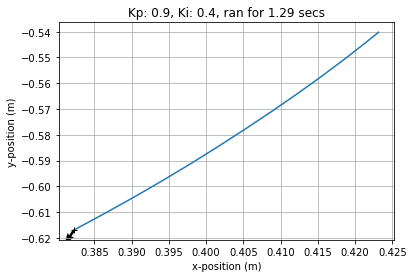

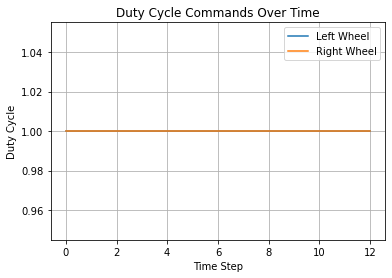

In [11]:
# Main control loop
from IPython import display


# Parameters
Kp = 0.9
Ki = 0.4

# Initialising
controller = RobotController(Kp, Ki)

poses = []
velocities = []
duty_cycle_commands = []


# Example: Move forward at 0.5 m/s with no rotation
v_desired = 0.5
w_desired = 0.0

start_time = time.time()

try:
    while True: 
        duty_cycle_l, duty_cycle_r = controller.drive(v_desired, w_desired, robot.wl, robot.wr)
        print(f"v_des: w_des: v_actual: w_actual:")
        x, y, th = robot.pose_update(duty_cycle_l, duty_cycle_r)
        
        # Log data
        poses.append([x,y,th])
        duty_cycle_commands.append([duty_cycle_l,duty_cycle_r])
        velocities.append([robot.wl,robot.wr])
        
        print(f"Position: ({x:.2f}, {y:.2f}), Orientation: {th:.2f}")
        
        time.sleep(robot.dt)

except KeyboardInterrupt:
    print("Stopping robot")
    robot.set_motor_speed(0, 0)
    end_time = time.time()
    duration = end_time - start_time
    # Plot robot data
#     plt.clf()
#     plt.cla()
    plt.figure()
    plt.plot(np.array(poses)[:,0],np.array(poses)[:,1])
    plt.plot(x,y,'k',marker='+')
    plt.quiver(x,y,0.1*np.cos(th),0.1*np.sin(th))
    plt.xlabel('x-position (m)')
    plt.ylabel('y-position (m)')
    plt.title(f"Kp: {Kp}, Ki: {Ki}, ran for {duration:.2f} secs")
    plt.grid()
#     display.clear_output(wait=True)
#     display.display(plt.gcf())

    plt.figure()
    duty_cycle_commands = np.array(duty_cycle_commands)
    plt.plot(duty_cycle_commands[:, 0], label='Left Wheel')
    plt.plot(duty_cycle_commands[:, 1], label='Right Wheel')
    plt.xlabel('Time Step')
    plt.ylabel('Duty Cycle')
    plt.title('Duty Cycle Commands Over Time')
    plt.legend() 
    plt.grid()
#     display.display(plt.gcf())

#     GPIO.cleanup()

    


In [ ]:
# duty_cycle_l, duty_cycle_r = controller.drive(0.5, 0, robot.wl, robot.wr)
# print(f"{duty_cycle_l}, {duty_cycle_r}")


# Some code that helps you to see if encoder calculations / odometry is working


OPTION = 0


if OPTION==1:
    robot.set_motor_speed(1, 1)


poses = []
velocities = []
duty_cycle_commands = []

# try:
#     while True:
#         if OPTION == 1:
# #             print(f"l: {robot.read_encoder(robot.ML_ENC)}, r: {robot.read_encoder(robot.MR_ENC)}")
#             wl, wr = robot.read_wheel_velocities()
#             print(f"{wl}, {wr}")

#         elif OPTION == 2:
#             x, y, th = robot.pose_update(1, 1)
#             poses.append([x,y,th])
#             velocities.append([robot.wl,robot.wr])
#             print(f"x:{x}, y:{y}, th: {th}\n")
        
#         time.sleep(robot.dt)
        
        
# except KeyboardInterrupt:
#     print("Stopping robot")
#     robot.set_motor_speed(0, 0)


In [ ]:
# plt.figure(figsize=(15,9))

graph = False

if graph:

    # Plot robot data
    plt.clf()
    plt.figure()

    plt.plot(np.array(poses)[:,0],np.array(poses)[:,1])
    # plt.plot(x,y,'k',marker='+')
    plt.quiver(x,y,0.1*np.cos(th),0.1*np.sin(th))
    # plt.plot(goal_x,goal_y,'x',markersize=5)
    # plt.quiver(goal_x,goal_y,0.1*np.cos(goal_th),0.1*np.sin(goal_th))
    # plt.xlim(-1,1)
    # plt.ylim(-1,1)
    plt.xlabel('x-position (m)')
    plt.ylabel('y-position (m)')
    plt.grid()


    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(range(len(np.array(velocities)[:,0])),np.array(velocities)[:,0])
    plt.subplot(1,2,2)
    plt.plot(range(len(np.array(velocities)[:,1])),np.array(velocities)[:,1])


    # plt.subplot(2,2,2)
    # plt.plot(np.arange(i+1)*robot.dt,np.array(duty_cycle_commands))
    # plt.xlabel('Time (s)')
    # plt.ylabel('Duty cycle')
    # plt.grid()

    # plt.subplot(2,2,4)
    # for i in range(300):
    #     plt.plot(np.arange(i+1)*robot.dt,np.array(velocities))

    #     plt.xlabel('Time (s)')
    # plt.ylabel('Wheel $\omega$')
    # plt.legend(['Left wheel', 'Right wheel'])
    # plt.grid()


    # display.clear_output(wait=True)
    display.display(plt.gcf())



In [ ]:
    plt.plot(np.array(poses)[:,0],np.array(poses)[:,1])
    plt.plot(x,y,'k',marker='+')
    plt.quiver(x,y,0.1*np.cos(th),0.1*np.sin(th))
    plt.xlabel('x-position (m)')
    plt.ylabel('y-position (m)')
    plt.grid()